# Autoencoder
最简单的自编码器，在本节，我们将尝试学习使用网络可视化技术。

Encoder - Decoder MSELoss

还是先引入常用包，和加载数据

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

transform = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)) ])

train_mnist = datasets.MNIST('./data', train = True, download = True, transform = transform)

train_loader = torch.utils.data.DataLoader(train_mnist, batch_size = 32, shuffle = True)



Processing...
Done!


OK, 下面定义这个简单的自编码器

In [10]:
help(nn.functional.sigmoid)

Help on function sigmoid in module torch.nn.functional:

sigmoid(input)



In [11]:
import torch.nn.functional as F
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Linear(784, 32, bias = False)
        self.decoder = nn.Linear(32, 784, bias = False)
        
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.sigmoid(self.encoder(x))
        x = F.sigmoid(self.decoder(x))
        return x

下面来进行训练

In [14]:
import torch.optim as optim
from torch.autograd import Variable
net = AutoEncoder()
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.5)

for epoch in range(30):
    for _, (inputs, _) in enumerate(train_loader, 0):
        inputs = Variable(inputs)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

    print('Epoch: %d, Loss: %.2f' % (epoch, loss.data[0]))

Epoch: 0, Loss: 1.24
Epoch: 1, Loss: 1.06
Epoch: 2, Loss: 1.02
Epoch: 3, Loss: 0.92
Epoch: 4, Loss: 0.91
Epoch: 5, Loss: 0.90
Epoch: 6, Loss: 0.97
Epoch: 7, Loss: 0.90
Epoch: 8, Loss: 0.88
Epoch: 9, Loss: 0.91
Epoch: 10, Loss: 0.84
Epoch: 11, Loss: 0.90
Epoch: 12, Loss: 0.87
Epoch: 13, Loss: 0.86
Epoch: 14, Loss: 0.84
Epoch: 15, Loss: 0.84
Epoch: 16, Loss: 0.82
Epoch: 17, Loss: 0.86
Epoch: 18, Loss: 0.80
Epoch: 19, Loss: 0.84
Epoch: 20, Loss: 0.83
Epoch: 21, Loss: 0.81
Epoch: 22, Loss: 0.82
Epoch: 23, Loss: 0.83
Epoch: 24, Loss: 0.82
Epoch: 25, Loss: 0.85
Epoch: 26, Loss: 0.77
Epoch: 27, Loss: 0.80
Epoch: 28, Loss: 0.78
Epoch: 29, Loss: 0.85


先可视化一下我们的encode权重

In [36]:
import matplotlib.pyplot as plt

def showGrid(grid):
    plt.imshow(grid)
    plt.show()

In [37]:
from torchvision.utils import make_grid
help(make_grid)

Help on function make_grid in module torchvision.utils:

make_grid(tensor, nrow=8, padding=2, normalize=False, range=None, scale_each=False, pad_value=0)
    Make a grid of images.
    
    Args:
        tensor (Tensor or list): 4D mini-batch Tensor of shape (B x C x H x W)
            or a list of images all of the same size.
        nrows (int, optional): Number of rows in grid. Final grid size is
            (B / nrow, nrow). Default is 8.
        normalize (bool, optional): If True, shift the image to the range (0, 1),
            by subtracting the minimum and dividing by the maximum pixel value.
        range (tuple, optional): tuple (min, max) where min and max are numbers,
            then these numbers are used to normalize the image. By default, min and max
            are computed from the tensor.
        scale_each(bool, optional): If True, scale each image in the batch of
            images separately rather than the (min, max) over all images.
        pad_value(float, opt

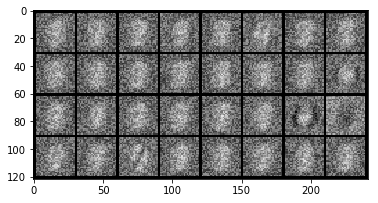

In [52]:
import numpy as np
# 将weights转换成0-1的图像
params = net.encoder.parameters()
for i, param in enumerate(params):
    # param is a 32 x 784 FloatTensor
    w = param.view(32, 28, 28, 1)
     
    # make_grid 只能接受(BxCxHxW)，所以我们能要转换过去
    w = np.transpose(w.data.numpy(), (0, 3, 1, 2))
    w = make_grid(torch.Tensor(w), normalize = True)
    w = np.transpose(w.numpy(), (1, 2, 0))
    
    # 4 * 8 每行四个
    # 下面我们将学习使用make_grid
    showGrid(w)

可爱吧？ 明显中间层想要努力表示这个数据集最主要的感觉。

如果想定义稀疏自编码器怎么办？记住稀疏的话，一定要用L1Norm，不能用L2Norm，研究表明L2Norm会让参数都趋向于很小，而L1会让参数趋向于多零。
惩罚因子要用KLDiv

一个超参数 $\rho$

一个基于激活的计算

$\hat{\rho} = \frac{1}{m}\sum_{i}^{m}h_i $

$ KL_{div} = \rho * log(\frac{\rho}{\hat{\rho}}) + (1 - \rho) * log(\frac{1 - \rho}{1 - \hat{\rho}})$

In [63]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Linear(784, 32, bias = False)
        self.decoder = nn.Linear(32, 784, bias = False)
        
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.sigmoid(self.encoder(x))
        self.hidden_x = x
        x = F.sigmoid(self.decoder(x))
        return x
net = AutoEncoder()

kl_criterion = nn.KLDivLoss()

beta = 0.05
rho = 0.02

for epoch in range(30):
    for _, (inputs, _) in enumerate(train_loader, 0):
        inputs = Variable(inputs)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        
        rho_hat = net.hidden_x.sum(1) / net.hidden_x.size(1)
        loss = criterion(outputs, inputs) + beta * kl_criterion(rho_hat, Variable(torch.Tensor([ rho ] * net.hidden_x.size(0))))
        loss.backward()
        optimizer.step()

    print('Epoch: %d, Loss: %.2f' % (epoch, loss.data[0]))

Epoch: 0, Loss: 1.27
Epoch: 1, Loss: 1.28
Epoch: 2, Loss: 1.28
Epoch: 3, Loss: 1.22
Epoch: 4, Loss: 1.32
Epoch: 5, Loss: 1.19
Epoch: 6, Loss: 1.23
Epoch: 7, Loss: 1.23
Epoch: 8, Loss: 1.26
Epoch: 9, Loss: 1.23
Epoch: 10, Loss: 1.33
Epoch: 11, Loss: 1.25
Epoch: 12, Loss: 1.21
Epoch: 13, Loss: 1.27
Epoch: 14, Loss: 1.24
Epoch: 15, Loss: 1.30
Epoch: 16, Loss: 1.20
Epoch: 17, Loss: 1.21
Epoch: 18, Loss: 1.28
Epoch: 19, Loss: 1.22
Epoch: 20, Loss: 1.29
Epoch: 21, Loss: 1.25
Epoch: 22, Loss: 1.27
Epoch: 23, Loss: 1.24
Epoch: 24, Loss: 1.26
Epoch: 25, Loss: 1.25
Epoch: 26, Loss: 1.31
Epoch: 27, Loss: 1.21
Epoch: 28, Loss: 1.23
Epoch: 29, Loss: 1.29


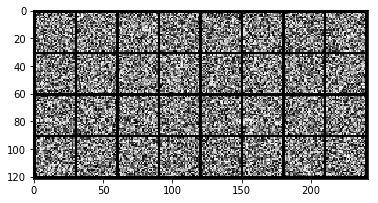

In [64]:
params = net.encoder.parameters()
for i, param in enumerate(params):
    # param is a 32 x 784 FloatTensor
    w = param.view(32, 28, 28, 1)
     
    # make_grid 只能接受(BxCxHxW)，所以我们能要转换过去
    w = np.transpose(w.data.numpy(), (0, 3, 1, 2))
    w = make_grid(torch.Tensor(w), normalize = True)
    w = np.transpose(w.numpy(), (1, 2, 0))
    
    # 4 * 8 每行四个
    # 下面我们将学习使用make_grid
    showGrid(w)

根本没有收敛下来，主要是稀疏编码的隐藏层数量要求更多

### 主要参考资料
- https://discuss.pytorch.org/t/autoencoders-in-pytorch/844/8
- https://ithelp.ithome.com.tw/articles/10188255
- https://github.com/siddharth-agrawal/Sparse-Autoencoder/blob/master/sparseAutoencoder.py